In [1]:
# %matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import subprocess
import scipy as sc
from itertools import product

mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "axes.labelsize": 12,
    "font.size": 12,
    "legend.fontsize": 10,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "figure.figsize": (4, 3.5),
    "text.latex.preamble": "\n".join([
        r"\usepackage[utf8]{inputenc}",
        r"\usepackage[T1]{fontenc}",
        r"\usepackage[detect-all,locale=FR]{siunitx}",
    ]),
    'lines.markersize': 10,
    'lines.color': 'grey',
    'scatter.marker': '+',
    'errorbar.capsize': 3,
    'savefig.bbox': 'tight',
})

In [2]:
path = '../'
executable = 'bin/ex2'
export_path = path + 'rapport/figures/'
data_path = 'data/'
config_path = 'bin/'
config_name = 'no_excitation'
config_ext = '.conf'

In [3]:
def stringify_dict(d: dict, sep=',') -> str:
    return sep.join(map(lambda a: str(a[0]) + "=" + str(a[1]), tuple(d.items())))

In [4]:
def run(config_file: str, output_file: str, params: dict = {}) -> None:
    # print(f"Running with config file {config_file}")
    options = stringify_dict(params, sep=' ')
    cmd = f"{path}{executable} {path}{config_file} output='{path}{output_file}' {options}"
    print(f"Running command `{cmd}`")
    subprocess.run(cmd, shell=True, stdout=subprocess.DEVNULL)
    # print("Done")

In [5]:
# nsteps = np.array([*range(500, 2001, 100)])
nsteps = np.array([10000])
nsimul = len(nsteps)  # Number of simulations to perform

conf = {}
with open(path + config_path + config_name + config_ext, 'r') as f:
    lines = f.read().split('\n')

for line in lines:
    if not line:
        continue
    name, _, val, *_ = line.split(' ')
    name = name.strip()
    val = val.strip()
    try:
        conf[name] = float(val)
    except ValueError:
        conf[name] = val

# 3 periodes
omega0 = np.sqrt(conf['g']/conf['L'])
tFin = 6 * np.pi / omega0
dt = conf['tFin'] / nsteps
assert conf['tFin'] == tFin
tFin

2.691420879279824

In [6]:
def analytical_theta(t: float) -> float:
    return conf['theta0'] * np.cos(omega0 * t)

In [7]:
def analytical_thetadot(t: float) -> float:
    return -omega0 * conf['theta0'] * np.sin(omega0 * t)

In [8]:
%%bash
cd .. && make clean && make

clang++ -o bin/ex2 src/Ex2_2024_student.cpp -std=c++17 -Wall -Wextra -O2 


In [9]:
params_variations = {
    'nsteps': nsteps,
    'theta0': np.linspace(0.1, np.pi - 0.1, 30),
}
all_params = tuple(
    {a: b for a, b in zip(params_variations.keys(), c)} for c in product(*params_variations.values())
)

# Run simulations
outputs = []  # List to store output file names
for params in all_params:
    output_file = f"{data_path}{config_name},{stringify_dict(params)}.out"
    outputs.append(output_file)
    run(f'{config_path}{config_name}{config_ext}', output_file, params)

Running command `../bin/ex2 ../bin/no_excitation.conf output='../data/no_excitation,nsteps=10000,theta0=0.1.out' nsteps=10000 theta0=0.1`
Running command `../bin/ex2 ../bin/no_excitation.conf output='../data/no_excitation,nsteps=10000,theta0=0.2014342294341308.out' nsteps=10000 theta0=0.2014342294341308`
Running command `../bin/ex2 ../bin/no_excitation.conf output='../data/no_excitation,nsteps=10000,theta0=0.3028684588682616.out' nsteps=10000 theta0=0.3028684588682616`
Running command `../bin/ex2 ../bin/no_excitation.conf output='../data/no_excitation,nsteps=10000,theta0=0.40430268830239235.out' nsteps=10000 theta0=0.40430268830239235`
Running command `../bin/ex2 ../bin/no_excitation.conf output='../data/no_excitation,nsteps=10000,theta0=0.5057369177365232.out' nsteps=10000 theta0=0.5057369177365232`
Running command `../bin/ex2 ../bin/no_excitation.conf output='../data/no_excitation,nsteps=10000,theta0=0.6071711471706539.out' nsteps=10000 theta0=0.6071711471706539`
Running command `../

In [10]:
# Filter stuff
file_and_params = []
all_data = {}

for file, params in zip(outputs, all_params):
    file_and_params.append((file, params))
    data = np.loadtxt(path + file)
    all_data[file] = (params, np.copy(data))

# Plots!

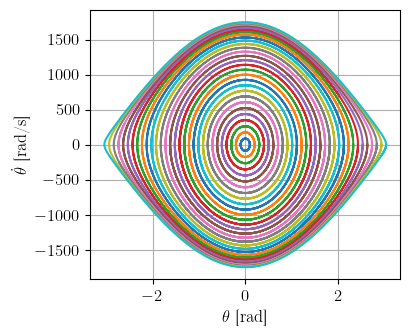

In [11]:
for (params, data) in all_data.values():
    t, theta, thetadot = data[:,0], data[:,1], data[:,2]
    # p = m L^2 thetadot
    plt.plot(theta, thetadot / (2 * conf['m'] * conf['L']**2))

# plt.axis('equal')
plt.xlabel(r'$\theta$ [rad]')
plt.ylabel(r'$\dot{\theta}$ [rad/s]')
plt.grid()
# plt.legend()
plt.savefig(export_path + 'feuriste.pdf')

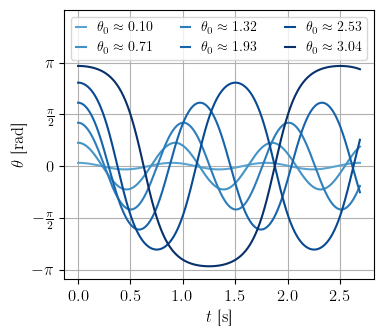

In [17]:
colors = mpl.colormaps['Blues'](np.geomspace(0.55, 1, len(all_data)))
for i, (params, data) in enumerate(all_data.values()):
    if i%6 != 0 and i != len(all_data)-1:
        continue
    t, theta, thetadot = data[:,0], data[:,1], data[:,2]
    plt.plot(t, theta, label=f"$\\theta_0 \\approx {params['theta0']:.2f}$", c=colors[i])

# plt.axis('equal')
plt.xlabel(r'$t$ [s]')
plt.ylabel(r'$\theta$ [rad]')
plt.ylim(-np.pi-0.3, np.pi+1.6)

ticks = np.arange(-np.pi, np.pi+0.1, np.pi/2)
labels = [
    r'$-\pi$', r'$-\frac{\pi}{2}$',
    r'$0$', r'$\frac{\pi}{2}$', r'$\pi$',
]
plt.yticks(ticks, labels)

plt.legend(ncols=3, handlelength=0.7)
plt.grid()
plt.savefig(export_path + "oscillations_trajectory.pdf")

In [99]:
periods = np.zeros(len(all_params))

for i, (params, data) in enumerate(all_data.values()):
    t, theta, thetadot = data[:,0], data[:,1], data[:,2]
    # Index of where thetadot change sign
    changes = np.where(thetadot[:-1] * thetadot[1:] < 0 )[0] +1
    total_period = t[changes[1]] - t[0]
    periods[i] = total_period
    print(total_period)

0.8978580053277
0.899472857855268
0.902433420822475
0.906470552141394
0.911853393899953
0.918312804010224
0.926387066648062
0.935537897637612
0.94630358115473
0.958414975111487
0.97241036368374
0.988020604783561
1.00551484049888
1.02516221291762
1.04723186412771
1.07172379412915
1.0991762870978
1.12985848512159
1.16430867237636
1.20333427512592
1.24720443545817
1.2975340059007
1.3553995548052
1.42295421887512
1.50288941898972
1.59951142855585
1.72062536812342
1.87968834208884
2.1076516905638
2.50436712816959


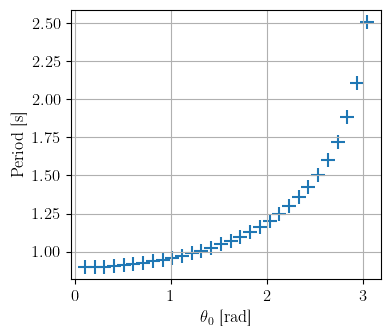

In [100]:
plt.scatter(params_variations['theta0'], periods)
plt.xlabel(r'$\theta_0$ [rad]')
plt.ylabel(r'Period [s]')
plt.grid()

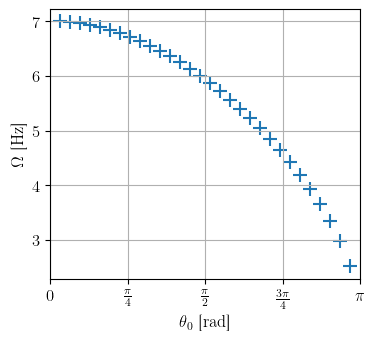

In [101]:
plt.scatter(params_variations['theta0'], 2*np.pi/periods)
plt.xlabel(r'$\theta_0$ [rad]')
plt.ylabel(r'$\Omega$ [Hz]')
plt.xlim(0, np.pi)
ticks = np.arange(0, np.pi+0.1, np.pi/4)
labels = [
    r'$0$', r'$\frac{\pi}{4}$', r'$\frac{\pi}{2}$', r'$\frac{3\pi}{4}$', r'$\pi$',
]
plt.xticks(ticks, labels)
plt.grid()
plt.savefig(export_path + "angular_frequency.pdf")